<a href="https://colab.research.google.com/github/mnocerino23/NBA-Player-Classifier/blob/main/NeuralNetwork_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a multi-class classifier with Neural Networks

In [508]:
import pandas as pd
import sklearn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [509]:
complete = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/NBA/complete22-23.csv')

In [510]:
complete.head(4)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST_TOV,OWS_div_USG,TS_times_USG,bigmanD,foul_rate,three_rate,PTs_per_36,PF_per_dplay,FG_TOV,two_way
0,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,...,0.818182,0.041237,10.7476,0.251208,0.091787,21.505376,16.000000,1.727273,3.727273,38.690909
1,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,0.597,...,1.210526,0.089041,8.2344,0.314815,0.085185,0.000000,11.466667,1.150000,1.947368,87.500000
2,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,0.540,...,1.280000,0.142857,14.9184,0.251445,0.080925,1.324503,21.225434,1.400000,3.200000,101.840000
3,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,...,1.571429,0.056962,8.8638,0.092683,0.082927,37.500000,13.873171,2.833333,6.000000,6.440678


In [511]:
#we want to make sure each player has only one position to limit the amount of categories for Pos.
#although we don't need to one hot encode for our tree based model, limiting all 
#entries to just one position is still important

for index, rows in complete.iterrows():
  #if the position has length greater than two (meaning it isn't C, PG, SG, SF, or PF), we shorten it to the first position
  if len(complete.at[index, 'Pos']) > 2:
    complete.at[index, 'Pos'] = complete.at[index, 'Pos'][:2]

# Players with salaries over 25 million will be considered max level players while those under with be considered "Not max"

In [512]:
#use a lambda function to assign classes
complete['Class'] = ''

for index, rows in complete.iterrows():
  salary = complete.at[index,'Salary']
  #low tier players with salary under 10 mil
  if salary <= 10:
    complete.at[index, 'Class'] = 0
  elif salary > 10 and salary <=25:
    #middle tier players with salary between 10-25 mil
    complete.at[index, 'Class'] = 1
  else:
    #star players with salary over 25 mil
    complete.at[index, 'Class'] = 2

In [513]:
#the count of each class in the dataset before splitting
complete['Class'].value_counts()

0    312
1     86
2     52
Name: Class, dtype: int64

Before splitting into train-test, we need to drop outliers that have been identified such as Kyle Lowry, John Wall, Gordon Hayward, and Ben Simmons. These are players who have all severly fallen off after receiving max contracts and should not appear in the training set.

In [514]:
#need to remove john wall, Gordon Hayward, Ben Simmons from the training set

In [515]:
need_to_remove = ['John Wall', 'Gordon Hayward', 'Ben Simmons']
for player in need_to_remove:
  complete = complete.drop(complete[complete['Player'] == player].index)

In [516]:
print(list(complete['Player']))

['Precious Achiuwa', 'Steven Adams', 'Bam Adebayo', 'Ochai Agbaji', 'Santi Aldama', 'Nickeil Alexander-Walker', 'Grayson Allen', 'Jarrett Allen', 'Jose Alvarado', 'Kyle Anderson', 'Giannis Antetokounmpo', 'Thanasis Antetokounmpo', 'Cole Anthony', 'OG Anunoby', 'Ryan Arcidiacono', 'Deni Avdija', 'Deandre Ayton', 'Udoka Azubuike', 'Marvin Bagley III', 'Patrick Baldwin Jr.', 'LaMelo Ball', 'Mo Bamba', 'Paolo Banchero', 'Desmond Bane', 'Dalano Banton', 'Dominick Barlow', 'Harrison Barnes', 'Scottie Barnes', 'RJ Barrett', 'Will Barton', 'Charles Bassey', 'Keita Bates-Diop', 'Nicolas Batum', 'Darius Bazley', 'Bradley Beal', 'Malik Beasley', 'MarJon Beauchamp', 'Dāvis Bertāns', 'Patrick Beverley', 'Saddiq Bey', 'Khem Birch', 'Goga Bitadze', 'Bismack Biyombo', 'Bogdan Bogdanović', 'Bojan Bogdanović', 'Bol Bol', 'Devin Booker', 'Brandon Boston Jr.', 'Chris Boucher', 'James Bouknight', 'Malaki Branham', 'Christian Braun', 'Mikal Bridges', 'Oshae Brissett', 'Malcolm Brogdon', 'Dillon Brooks', 'Br

In [517]:
from sklearn.model_selection import train_test_split, cross_val_score

In [518]:
#one hot encode position
dummies = pd.get_dummies(complete['Pos'], prefix = 'Pos')

In [519]:
dummies.head(3)

,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0


In [520]:
#concat the one-hot encoded columns and drop the original Pos column
complete = pd.concat([complete,dummies], axis = 1)
complete = complete.drop(columns = ['Pos'], axis = 1)

In [521]:
#check that this worked
complete.head(5)

,Player,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,...,PTs_per_36,PF_per_dplay,FG_TOV,two_way,Class,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,Precious Achiuwa,23,TOR,55,12,20.7,3.6,7.3,0.485,0.5,...,16.000000,1.727273,3.727273,38.690909,0,1,0,0,0,0
1,Steven Adams,29,MEM,42,42,27.0,3.7,6.3,0.597,0.0,...,11.466667,1.150000,1.947368,87.500000,1,1,0,0,0,0
2,Bam Adebayo,25,MIA,75,75,34.6,8.0,14.9,0.540,0.0,...,21.225434,1.400000,3.200000,101.840000,2,1,0,0,0,0
3,Ochai Agbaji,22,UTA,59,22,20.5,2.8,6.5,0.427,1.4,...,13.873171,2.833333,6.000000,6.440678,0,0,0,0,0,1
4,Santi Aldama,22,MEM,77,20,21.8,3.2,6.8,0.470,1.2,...,14.862385,1.583333,5.500000,43.324675,0,0,1,0,0,0


In [522]:
#split into input features and target variable class
X = complete.drop(columns = ['Salary', 'Class'], axis = 1)
y = complete['Class']

In [523]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, test_size=0.2, shuffle = True)

In [524]:
#X_train.loc[X_train['Class'] == 1]['Player']

In [525]:
#drop the names column before proceeding
names_train = list(X_train['Player'])
X_train.drop(columns = ['Player', 'Tm'], axis = 1, inplace = True)
names_test = list(X_test['Player'])
X_test.drop(columns = ['Player', 'Tm'], axis = 1, inplace = True)

In [526]:
print('Train:')
print('train_features dimensions: ', X_train.shape)
print('train_target dimensions: ', y_train.shape, '\n')


print('Test:')
print('test_features dimensions: ', X_test.shape)
print('test_target dimensions: ', y_test.shape)

Train:
train_features dimensions:  (357, 64)
train_target dimensions:  (357,) 

Test:
test_features dimensions:  (90, 64)
test_target dimensions:  (90,)


In [527]:
import numpy as np
#the labels need to be in the format
#of int32 to be used by TF

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# Neural Network 1
*   64 Input features
*   30 Neurons, ReLu Activation
*   60 Neurons, ReLu Activation
*   60 Neurons, ReLu Activation
*   60 Neurons, ReLu Activation
*   30 Neurons, ReLu Activation
*   3 Neurons, Softmax Activation 



*   15 Epochs, Adam Optimization










In [528]:
#build the neural network

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(5)

nn = tf.keras.models.Sequential()
nn.add(tf.keras.Input(shape=(64,)))
nn.add(tf.keras.layers.Dense(30, activation='relu'))
nn.add(tf.keras.layers.Dense(60, activation='relu'))
nn.add(tf.keras.layers.Dense(60, activation='relu'))
nn.add(tf.keras.layers.Dense(60, activation='relu'))
nn.add(tf.keras.layers.Dense(30, activation='relu'))
nn.add(tf.keras.layers.Dense(3, activation='softmax'))

#use Sparse Categorical Crossentropy loss function since we
#are building a multiclass classifier

nn.compile(
   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics="accuracy")

nn_one = nn.fit(X_train, y_train, epochs= 15,validation_data=(X_test,y_test))

Epoch 1/15
12/12 [==============================] - 1s 27ms/step - loss: 1.2341 - accuracy: 0.5770 - val_loss: 0.7688 - val_accuracy: 0.7111
Epoch 2/15
12/12 [==============================] - 0s 6ms/step - loss: 0.6711 - accuracy: 0.7311 - val_loss: 0.5973 - val_accuracy: 0.7556
Epoch 3/15
12/12 [==============================] - 0s 6ms/step - loss: 0.6126 - accuracy: 0.7311 - val_loss: 0.5617 - val_accuracy: 0.7778
Epoch 4/15
12/12 [==============================] - 0s 7ms/step - loss: 0.5616 - accuracy: 0.7535 - val_loss: 0.5648 - val_accuracy: 0.7667
Epoch 5/15
12/12 [==============================] - 0s 7ms/step - loss: 0.5277 - accuracy: 0.7731 - val_loss: 0.5538 - val_accuracy: 0.8111
Epoch 6/15
12/12 [==============================] - 0s 7ms/step - loss: 0.5248 - accuracy: 0.7955 - val_loss: 0.5444 - val_accuracy: 0.8222
Epoch 7/15
12/12 [==============================] - 0s 7ms/step - loss: 0.4849 - accuracy: 0.8067 - val_loss: 0.5381 - val_accuracy: 0.8333
Epoch 8/15
12/12 [=

Plotting 

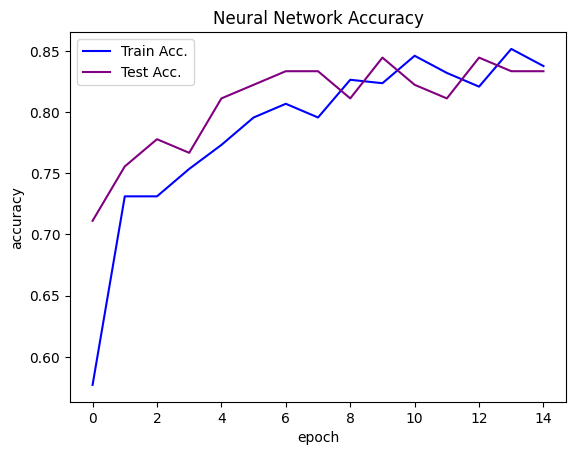

In [529]:
from matplotlib import pyplot as plt

plt.plot(nn_one.history['accuracy'], color = 'blue')
plt.plot(nn_one.history['val_accuracy'], color = 'purple')
plt.title('Neural Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Acc.', 'Test Acc.'], loc='upper left')
plt.show()

In [531]:
from sklearn.metrics import confusion_matrix

# Assuming you have already trained your neural network and obtained predictions
predictions = nn.predict(X_test)
y_predicted = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Obtain the confusion matrix
confusion = confusion_matrix(y_test, y_predicted)

print(confusion)

3/3 [==============================] - 0s 3ms/step
[[59  4  0]
 [ 7  8  2]
 [ 2  0  8]]


In [539]:
# Specify the file path and name to save the model
#to colab and download on my pc

nn.save('model.h5')